In [2]:
# Import packages and data
from fastai.vision import *


path = Path("/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet11/fastAITesting")

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.1,
                      max_rotate=0.0, 
                      max_zoom=0.0,
                      max_warp=0.0,
                      p_affine=0.0)

# data = ImageDataBunch.from_folder(path, test='test', ds_tfms=get_transforms(), size=224)
data_test = ImageDataBunch.from_folder(path,
                                  train='train',
                                  valid='test',
                                  ds_tfms= tfms,
                                  size=224).normalize()

The accuracy is 0.587649405002594 %.
ROC area is 0.5885850373655253


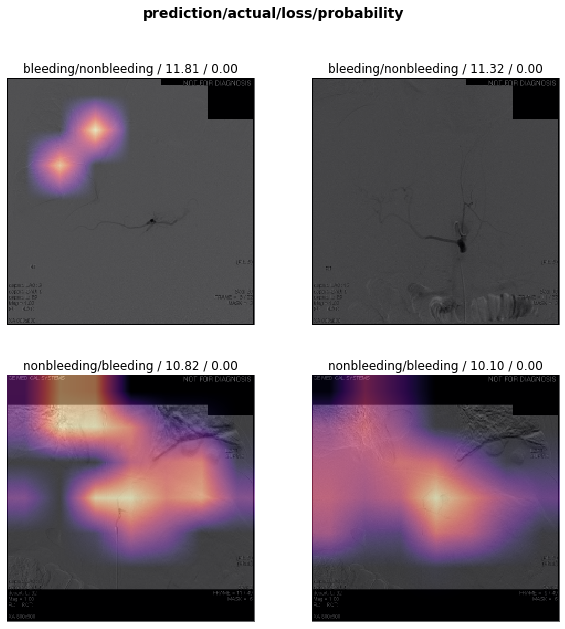

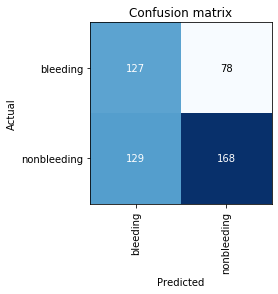

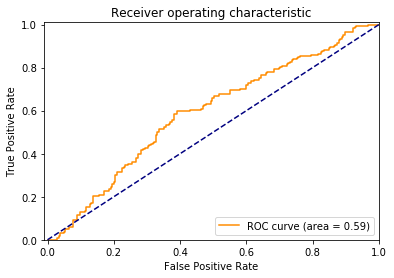

In [3]:
from fastai.vision import *

# Try to use the ResNet-152 model to test
# make sure we have the best performing model stage loaded
learner152 = cnn_learner(data_test, models.resnet152, metrics=accuracy)
learner152.load( "/Users/mingrenshen/Projects/MedicalImgAnalysis/resultsModelWeight/stage3/dataset11/freeze5layer/res152-TneqV-run300")
learner152.validate(data_test.valid_dl)
interp = ClassificationInterpretation.from_learner(learner152)
interp.plot_top_losses(4, figsize=(10,10))
tmpfig=interp.plot_confusion_matrix(return_fig=True)
tmpfig.savefig('confusion.png', dpi=300)

preds,y, loss = learner152.get_preds(ds_type=DatasetType.Valid,with_loss=True) #ds_type=DatasetType.Test,
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

# from fastai.vision import *
# from torchvision.modeals import *    # import *=all the models from torchvision  
# #interp = ClassificationInterpretation.from_learner(learner)
# plot_overview(interp, ['nonbleeding','bleeding'])
# plot_heatmap_overview(interp, ['nonbleeding','bleeding'])
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
newfig=plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
newfig.savefig('roc.png', dpi=300)

# Analysize the predictions

In [4]:
# Generate Report of Performance

print(len(data_test.valid_ds.items)) # should be 502 as the total testing image numbers

with open("performanceNeg.csv",'w') as perfcsvNeg:
    with open("performancePos.csv",'w') as perfcsvPos:
        perfcsvNeg.write("%s,%s,%s,%s\n"%("IMG",'ID',"Pred","GT"))
        perfcsvPos.write("%s,%s,%s,%s\n"%("IMG",'ID',"Pred","GT"))
        for i in range(len(data_test.valid_ds.items)):
            # Bleeding
            fnames = data_test.valid_ds.items[i].name.split('.')
            if y[i].item() == 0:
                perfcsvPos.write("%s,%s,%d,%d\n"%(data_test.valid_ds.items[i].name,'a'+fnames[1].zfill(3),np.argmax(preds[i].numpy()),y[i].item()))
            if y[i].item() == 1:
                perfcsvNeg.write("%s,%s,%d,%d\n"%(data_test.valid_ds.items[i].name,'a'+fnames[1].zfill(3),np.argmax(preds[i].numpy()),y[i].item()))

502


In [45]:
gtBleedingCSV = pd.read_csv("Analysis2/bleedingInfo.csv",header=0)
for index, row in gtBleedingCSV.iterrows():
    gtBleedingCSV.loc[index,'IMG'] = row['newfileName '].split('/')[-1].rstrip()
gtBleedingCSV.head()

,imgID,patientID,label,oldfilename,newfileName,IMG
0,1,Patient 1027,Bleeding,1027_10_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.1.jpg
1,2,Patient 1027,Bleeding,1027_12_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.2.jpg
2,3,Patient 1027,Bleeding,1027_9_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.3.jpg
3,4,Patient 1027,Bleeding,1027_11_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.4.jpg
4,5,Patient 1027,Bleeding,1027_8_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.5.jpg


In [46]:
predCSV = pd.read_csv("Analysis2/performancePos.csv",header=0)
predCSV.head()

,IMG,ID,Pred,GT
0,bleeding.2.jpg,a002,1,0
1,bleeding.70.jpg,a070,1,0
2,bleeding.64.jpg,a064,0,0
3,bleeding.58.jpg,a058,0,0
4,bleeding.109.jpg,a109,0,0


In [48]:
df_final = gtBleedingCSV.merge(predCSV, on="IMG")
df_final.head()

,imgID,patientID,label,oldfilename,newfileName,IMG,ID,Pred,GT
0,1,Patient 1027,Bleeding,1027_10_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.1.jpg,a001,1,0
1,2,Patient 1027,Bleeding,1027_12_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.2.jpg,a002,1,0
2,3,Patient 1027,Bleeding,1027_9_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.3.jpg,a003,1,0
3,4,Patient 1027,Bleeding,1027_11_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.4.jpg,a004,1,0
4,5,Patient 1027,Bleeding,1027_8_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.5.jpg,a005,0,0


In [66]:
# since GT is always 0 for Bleeding cases
# we only need to count all 1 in `df_final` since the 1 is the wrong predictions
A = df_final.groupby('patientID').sum()
B = df_final.groupby('patientID').count()

Correct = B.Pred - A.Pred
score = (1.0 * Correct/B.Pred)
# then let's get the correct predictions for the bleeding patients
# B - A is the answer

In [67]:
# merge results and for the final output
B['correct'] = Correct
B['score'] = score 

In [69]:
B.to_csv("BleedingSummaryScores.csv")

# Then we check non bleeding cases

In [76]:
gtNonBleedingCSV = pd.read_csv("Analysis2/nonbleedingInfo.csv",header=0)
for index, row in gtNonBleedingCSV.iterrows():
     gtNonBleedingCSV.loc[index,'IMG'] = row['newfileName '].rstrip()
gtNonBleedingCSV.head()

,imgID,patientID,seriesID,label,oldfilename,newfileName,IMG
0,1,Patient 1018,Series 4,nonBleeding,B1018_10_25.jpg,nonbleeding.1.jpg,nonbleeding.1.jpg
1,2,Patient 1018,Series 4,nonBleeding,B1018_9_25.jpg,nonbleeding.2.jpg,nonbleeding.2.jpg
2,3,Patient 1018,Series 4,nonBleeding,B1018_18_25.jpg,nonbleeding.3.jpg,nonbleeding.3.jpg
3,4,Patient 1018,Series 4,nonBleeding,B1018_14_25.jpg,nonbleeding.4.jpg,nonbleeding.4.jpg
4,5,Patient 1018,Series 4,nonBleeding,B1018_11_25.jpg,nonbleeding.5.jpg,nonbleeding.5.jpg


In [72]:
predNonCSV = pd.read_csv("Analysis2/performanceNeg.csv",header=0)
predNonCSV.head()

,IMG,ID,Pred,GT
0,nonbleeding.210.jpg,a210,0,1
1,nonbleeding.204.jpg,a204,0,1
2,nonbleeding.238.jpg,a238,1,1
3,nonbleeding.166.jpg,a166,1,1
4,nonbleeding.172.jpg,a172,1,1


In [78]:
df_final = gtNonBleedingCSV.merge(predNonCSV, on="IMG")
df_final.head()

,imgID,patientID,seriesID,label,oldfilename,newfileName,IMG,ID,Pred,GT
0,1,Patient 1018,Series 4,nonBleeding,B1018_10_25.jpg,nonbleeding.1.jpg,nonbleeding.1.jpg,a001,0,1
1,2,Patient 1018,Series 4,nonBleeding,B1018_9_25.jpg,nonbleeding.2.jpg,nonbleeding.2.jpg,a002,0,1
2,3,Patient 1018,Series 4,nonBleeding,B1018_18_25.jpg,nonbleeding.3.jpg,nonbleeding.3.jpg,a003,0,1
3,4,Patient 1018,Series 4,nonBleeding,B1018_14_25.jpg,nonbleeding.4.jpg,nonbleeding.4.jpg,a004,0,1
4,5,Patient 1018,Series 4,nonBleeding,B1018_11_25.jpg,nonbleeding.5.jpg,nonbleeding.5.jpg,a005,0,1


In [84]:
# since GT is always 1 for Bleeding cases
# we only need to count all 1 in `df_final` since the 1 is the correct predictions
A = df_final.groupby(['patientID','seriesID']).sum()
B = df_final.groupby(['patientID','seriesID']).count()

Correct = A.Pred
score = (1.0 * Correct/B.Pred)
# then let's get the correct predictions for the bleeding patients
# B - A is the answer
# merge results and for the final output
B['correct'] = Correct
B['score'] = score 
B.to_csv("NonBleedingSummaryScores.csv")

patientID     seriesID  
Patient 1001  Series 1      29
              Series 2      19
              Series 3       0
Patient 1008  Series 1      10
              Series 4      10
Patient 1013  Series 1      12
              Series 8       4
Patient 1015  Series 1       2
Patient 1018  Series 2       5
              Series 3       3
              Series 4       1
              Series 8       8
Patient 1020  Series 1      10
              Series 10      0
              Series 2      14
              Series 20      4
              Series 9      29
Patient 1023  Sequence 1     7
              Sequence 5     1
Name: Pred, dtype: int64

In [81]:
len(gtNonBleedingCSV)

297

In [83]:
len(df_final)

297